### Code Hist.

 - CODE : KIER M02 - Clustering
 - DESC  
    &ensp; : 최적의 Cluster를 선정하기 위한 정량적 비교  
    &emsp; 1) Inertia 기반의 Elbow-Method  
    &emsp; 2) 군집화 계수 비교 : Silhouette / CHI / Dunn Index  

  - DATE  
    &ensp; 2024-02-01 Created  
    &ensp; 2024-04-03 코드 개선  
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp; 1) KIER M02 초기부분 공통코드화  
    &ensp; 2024-04-04 Updated  
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp; 1) 기능 구현 완료 및 논문 작성    
    &ensp; 2024-07-23 Updated  
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp; 1) Dunn Index 부분 추가    

# 01. Code

## 01-01. Init

### 01-01-01. Init_Module Import

In [1]:
#region Basic_Import
## Basic
import os, sys, warnings
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.path.dirname(os.path.abspath('./__file__'))
sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname('./__file__'))))
warnings.filterwarnings('ignore')

import numpy as np, pandas as pd
from pandas import DataFrame, Series
pd.options.display.float_format = '{:.10f}'.format

import math, random

## Datetime
import time, datetime as dt
from datetime import datetime, date, timedelta

## glob
import glob, requests, json
from glob import glob

## 시각화
import matplotlib.pyplot as plt, seaborn as sns
# %matplotlib inline
plt.rcParams['figure.figsize'] = [10, 8]

from scipy import stats

## Split, 정규화
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# K-Means 알고리즘
from sklearn.cluster import KMeans, MiniBatchKMeans

# Clustering 알고리즘의 성능 평가 측도
from sklearn import metrics
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score, adjusted_rand_score, silhouette_score, rand_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics.cluster import contingency_matrix

## For Web
import urllib
from urllib.request import urlopen
from urllib.parse import urlencode, unquote, quote_plus
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup

import tqdm
from tqdm.notebook import tqdm
#endregion Basic_Import

In [2]:
## Import_DL
str_tar = "tf"
## For Torch
if str_tar == "torch":
    import torch, torch.nn as nn
    from torch.nn.utils import weight_norm
    print("Torch Imported")
## For TF
elif str_tar == "tf":
    import tensorflow as tf, tensorflow_addons as tfa
    from keras.callbacks import EarlyStopping, ModelCheckpoint
    from keras.models import Sequential, load_model
    from keras_flops import get_flops
    print("Tensorflow Imported")
else:
    print("Error : Cannot be used except for Keywords")
    print(" : torch / tf")

Tensorflow Imported


In [3]:
## Import_Local
from Src_Dev_Common import Data_Datetime as com_date, KMA_Weather as com_KMA, KECO_AirKor as com_KECO, KASI_Holiday as com_Holi, KIER_Usage_M02 as com_KIER_M02, Data_Clustering as com_clustering

### 01-01-02. Config (Directory, Params)

In [4]:
## Init_config
SEED = 42

np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)
os.environ["PYTHONHASHSEED"], os.environ['TF_DETERMINISTIC_OPS'] = str(SEED), "1"

In [5]:
## Define Todate str
str_now_ymd = pd.datetime.now().date()
str_now_y, str_now_m, str_now_d = pd.datetime.now().year, pd.datetime.now().month, pd.datetime.now().day
str_now_hr, str_now_min = pd.datetime.now().hour, pd.datetime.now().minute

print(pd.datetime.now())
print(str(str_now_y) + " / " + str(str_now_m)  + " / " + str(str_now_d))
print(str(str_now_hr) + " : " + str(str_now_min))

2024-10-08 11:13:18.293830
2024 / 10 / 8
11 : 13


In [6]:
## Dict_Domain
## {0:"ELEC", 1:"HEAT", 2:"WATER", 3:"HOT_HEAT", 4:"HOT_FLOW", 99:"GAS"}
## {'10min', '1H', '1D', '1W', '1M'}
int_domain, int_interval = 0, 2

## Domain, ACCU/INST Column
str_domain, str_col_accu, str_col_inst = com_KIER_M02.create_domain_str(int_domain)
## Directory Root
str_dirData, str_dir_raw, str_dir_cleansed, str_dirName_bld, str_dirName_h = com_KIER_M02.create_dir_str(str_domain)
## Interval, Target File
str_interval, str_fileRaw, str_fileRaw_hList, str_file = com_KIER_M02.create_file_str(str_domain, int_interval)

print(str(os.listdir(str_dirData)) + "\n")
print(os.listdir(str_dirName_h))

0 : ELEC
str_fileRaw : KIER_RAW_ELEC_2024-06-07.csv
str_fileRaw_hList : KIER_RAW_ELEC_2024-06-07.csv
str_file : KIER_ELEC_INST_1D_Resampled.csv
['.ipynb_checkpoints', 'BS_CONFIGURATION_202309251452.csv', 'DATE_1M_2023-10-20.csv', 'KIER 전처리 현황_2024-06-25.xlsx', 'KIER_0_Raw', 'KIER_1_Cleansed', 'KIER_2_BLD', 'KIER_3_H_ELEC', 'KIER_3_H_GAS', 'KIER_3_H_HEAT', 'KIER_3_H_HOT_FLOW', 'KIER_3_H_HOT_HEAT', 'KIER_3_H_WATER', 'KIER_ASOS_WEATHER_DAILY_202309251521.csv', 'KIER_ASOS_WEATHER_HOUR_202309251521.csv', 'KIER_DATA_OLD', 'KIER_ETC', 'KIER_hList_Comparison_2024-06-26.xlsx', 'KIER_List_Table_Column_2023-09-25.xlsx', 'KIER_Query_2023-09-25.txt', 'KMA_ASOS_119_2010_2023_1st_to CSV.csv', '[IITP] 데이터 테이블 정리 (공유 원본).docx']

['KIER_ELEC_561-1-1_ACCU_01_Raw.csv', 'KIER_ELEC_561-1-2_ACCU_01_Raw.csv', 'KIER_ELEC_561-1-3_ACCU_01_Raw.csv', 'KIER_ELEC_561-1-4_ACCU_01_Raw.csv', 'KIER_ELEC_561-10-1_ACCU_01_Raw.csv', 'KIER_ELEC_561-10-2_ACCU_01_Raw.csv', 'KIER_ELEC_561-10-3_ACCU_01_Raw.csv', 'KIER_ELEC_561-

## 01-02. Data Load (df_raw)

### 01-02-01. KIER (Energy Usage)

In [7]:
str_file = str('KIER_' + str_domain + '_INST_03_IQR.csv')
df_kier_raw = pd.read_csv(str_dirName_h + str_file, index_col = 0)
df_kier_raw['METER_DATE'] = pd.to_datetime(df_kier_raw['METER_DATE'])
print(df_kier_raw.isna().sum().sum())
df_kier_raw

0


,METER_DATE,YEAR,MONTH,DAY,HOUR,MINUTE,ELEC_INST_EFF_561-1-1,ELEC_INST_EFF_561-1-2,ELEC_INST_EFF_561-1-3,ELEC_INST_EFF_561-1-4,...,ELEC_INST_EFF_563-22-5,ELEC_INST_EFF_563-22-6,ELEC_INST_EFF_563-23-1,ELEC_INST_EFF_563-23-2,ELEC_INST_EFF_563-23-3,ELEC_INST_EFF_563-23-4,ELEC_INST_EFF_563-24-1,ELEC_INST_EFF_563-24-2,MEAN_OF_INST,SUM_OF_INST
0,2022-07-17 23:20:00,2022,7,17,23,20,0.1700000000,0.1700000000,0.0400000000,0.2900000000,...,0.0300000000,0.0400000000,0.0500000000,0.0800000000,0.0600000000,0.0600000000,0.0300000000,0.1000000000,0.0800086207,27.8430000000
1,2022-07-17 23:30:00,2022,7,17,23,30,0.1600000000,0.1800000000,0.0300000000,0.2100000000,...,0.0200000000,0.0400000000,0.0600000000,0.0600000000,0.0500000000,0.0772916667,0.0200000000,0.0900000000,0.0772916667,26.8975000000
2,2022-07-17 23:40:00,2022,7,17,23,40,0.1400000000,0.2300000000,0.0300000000,0.2400000000,...,0.0400000000,0.0300000000,0.0500000000,0.0600000000,0.0500000000,0.0759064327,0.0300000000,0.0900000000,0.0759064327,26.4154385965
3,2022-07-17 23:50:00,2022,7,17,23,50,0.1400000000,0.2100000000,0.0200000000,0.2700000000,...,0.0400000000,0.0400000000,0.0400000000,0.0600000000,0.0400000000,0.0500000000,0.0300000000,0.0800000000,0.0738053097,25.6842477876
4,2022-07-18 00:00:00,2022,7,18,0,0,0.1500000000,0.2100000000,0.0300000000,0.2200000000,...,0.0400000000,0.0400000000,0.0300000000,0.0600000000,0.0600000000,0.0300000000,0.0200000000,0.0600000000,0.0706528190,24.5871810089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99165,2024-06-05 14:50:00,2024,6,5,14,50,0.0400000000,0.0600000000,0.2300000000,0.0300000000,...,0.0400000000,0.0511049724,0.0511049724,0.0511049724,0.0511049724,0.0511049724,0.0511049724,0.0511049724,0.0511049724,17.7845303867
99166,2024-06-05 15:00:00,2024,6,5,15,0,0.0300000000,0.0600000000,0.3400000000,0.0300000000,...,0.0800000000,0.0477714286,0.0477714286,0.0477714286,0.0477714286,0.0477714286,0.0477714286,0.0477714286,0.0477714286,16.6244571429
99167,2024-06-05 15:10:00,2024,6,5,15,10,0.0500000000,0.0700000000,0.2900000000,0.0200000000,...,0.0500000000,0.0453977273,0.0453977273,0.0453977273,0.0453977273,0.0453977273,0.0453977273,0.0453977273,0.0453977273,15.7984090909
99168,2024-06-05 15:20:00,2024,6,5,15,20,0.0500000000,0.1000000000,0.1300000000,0.0200000000,...,0.0900000000,0.0515517241,0.0515517241,0.0515517241,0.0515517241,0.0515517241,0.0515517241,0.0515517241,0.0508045977,17.6800000000


In [8]:
## 호실별 순시 사용량 컬럼만 가져오기
list_col_tar = list(df_kier_raw.columns[6:-2])
df_kier_h = df_kier_raw.set_index('METER_DATE')
df_kier_h

,YEAR,MONTH,DAY,HOUR,MINUTE,ELEC_INST_EFF_561-1-1,ELEC_INST_EFF_561-1-2,ELEC_INST_EFF_561-1-3,ELEC_INST_EFF_561-1-4,ELEC_INST_EFF_561-2-1,...,ELEC_INST_EFF_563-22-5,ELEC_INST_EFF_563-22-6,ELEC_INST_EFF_563-23-1,ELEC_INST_EFF_563-23-2,ELEC_INST_EFF_563-23-3,ELEC_INST_EFF_563-23-4,ELEC_INST_EFF_563-24-1,ELEC_INST_EFF_563-24-2,MEAN_OF_INST,SUM_OF_INST
METER_DATE,,,,,,,,,,,,,,,,,,,,,
2022-07-17 23:20:00,2022,7,17,23,20,0.1700000000,0.1700000000,0.0400000000,0.2900000000,0.1800000000,...,0.0300000000,0.0400000000,0.0500000000,0.0800000000,0.0600000000,0.0600000000,0.0300000000,0.1000000000,0.0800086207,27.8430000000
2022-07-17 23:30:00,2022,7,17,23,30,0.1600000000,0.1800000000,0.0300000000,0.2100000000,0.1300000000,...,0.0200000000,0.0400000000,0.0600000000,0.0600000000,0.0500000000,0.0772916667,0.0200000000,0.0900000000,0.0772916667,26.8975000000
2022-07-17 23:40:00,2022,7,17,23,40,0.1400000000,0.2300000000,0.0300000000,0.2400000000,0.1400000000,...,0.0400000000,0.0300000000,0.0500000000,0.0600000000,0.0500000000,0.0759064327,0.0300000000,0.0900000000,0.0759064327,26.4154385965
2022-07-17 23:50:00,2022,7,17,23,50,0.1400000000,0.2100000000,0.0200000000,0.2700000000,0.1500000000,...,0.0400000000,0.0400000000,0.0400000000,0.0600000000,0.0400000000,0.0500000000,0.0300000000,0.0800000000,0.0738053097,25.6842477876
2022-07-18 00:00:00,2022,7,18,0,0,0.1500000000,0.2100000000,0.0300000000,0.2200000000,0.1400000000,...,0.0400000000,0.0400000000,0.0300000000,0.0600000000,0.0600000000,0.0300000000,0.0200000000,0.0600000000,0.0706528190,24.5871810089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-05 14:50:00,2024,6,5,14,50,0.0400000000,0.0600000000,0.2300000000,0.0300000000,0.1000000000,...,0.0400000000,0.0511049724,0.0511049724,0.0511049724,0.0511049724,0.0511049724,0.0511049724,0.0511049724,0.0511049724,17.7845303867
2024-06-05 15:00:00,2024,6,5,15,0,0.0300000000,0.0600000000,0.3400000000,0.0300000000,0.0700000000,...,0.0800000000,0.0477714286,0.0477714286,0.0477714286,0.0477714286,0.0477714286,0.0477714286,0.0477714286,0.0477714286,16.6244571429
2024-06-05 15:10:00,2024,6,5,15,10,0.0500000000,0.0700000000,0.2900000000,0.0200000000,0.0700000000,...,0.0500000000,0.0453977273,0.0453977273,0.0453977273,0.0453977273,0.0453977273,0.0453977273,0.0453977273,0.0453977273,15.7984090909


In [9]:
# ## Error Log : "[5:-2]" 부분을 추가하여 연월일시 및 평균합계 부분을 제거해주지 않으면, 군집화 계수가 제대로 도출되지 못함.
# df_kier_summary_total = df_kier_h.transpose().reset_index()[5:-2]
# ## 또는, 가장 깔끔하게 이렇게 처리해도 좋다
df_kier_summary_total = df_kier_h[list_col_tar].transpose().reset_index()

## 세대 번호의 컬럼명이 'index'로 지정되어 오류 발생
df_kier_summary_total['h_index'] = df_kier_summary_total['index']
df_kier_summary_total = df_kier_summary_total.drop(columns = ['index'])
df_kier_summary_total

METER_DATE,2022-07-17 23:20:00,2022-07-17 23:30:00,2022-07-17 23:40:00,2022-07-17 23:50:00,2022-07-18 00:00:00,2022-07-18 00:10:00,2022-07-18 00:20:00,2022-07-18 00:30:00,2022-07-18 00:40:00,2022-07-18 00:50:00,...,2024-06-05 14:10:00,2024-06-05 14:20:00,2024-06-05 14:30:00,2024-06-05 14:40:00,2024-06-05 14:50:00,2024-06-05 15:00:00,2024-06-05 15:10:00,2024-06-05 15:20:00,2024-06-05 15:30:00,h_index
0,0.1700000000,0.1600000000,0.1400000000,0.1400000000,0.1500000000,0.1500000000,0.1200000000,0.1400000000,0.1600000000,0.1300000000,...,0.0500000000,0.0500000000,0.0600000000,0.0500000000,0.0400000000,0.0300000000,0.0500000000,0.0500000000,0.0000000000,ELEC_INST_EFF_561-1-1
1,0.1700000000,0.1800000000,0.2300000000,0.2100000000,0.2100000000,0.2000000000,0.2100000000,0.2100000000,0.2100000000,0.2100000000,...,0.0700000000,0.0700000000,0.0600000000,0.0700000000,0.0600000000,0.0600000000,0.0700000000,0.1000000000,0.0000000000,ELEC_INST_EFF_561-1-2
2,0.0400000000,0.0300000000,0.0300000000,0.0200000000,0.0300000000,0.0400000000,0.0300000000,0.0200000000,0.0300000000,0.0400000000,...,0.0800000000,0.0900000000,0.3000000000,0.1500000000,0.2300000000,0.3400000000,0.2900000000,0.1300000000,0.0000000000,ELEC_INST_EFF_561-1-3
3,0.2900000000,0.2100000000,0.2400000000,0.2700000000,0.2200000000,0.0687500000,0.0646376812,0.2300000000,0.2100000000,0.1300000000,...,0.0563013699,0.0300000000,0.0300000000,0.0400000000,0.0300000000,0.0300000000,0.0200000000,0.0200000000,0.0000000000,ELEC_INST_EFF_561-1-4
4,0.1800000000,0.1300000000,0.1400000000,0.1500000000,0.1400000000,0.1400000000,0.1400000000,0.1400000000,0.1500000000,0.1300000000,...,0.0800000000,0.0800000000,0.0900000000,0.0800000000,0.1000000000,0.0700000000,0.0700000000,0.0800000000,0.0000000000,ELEC_INST_EFF_561-2-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343,0.0800000000,0.0600000000,0.0600000000,0.0600000000,0.0600000000,0.0700000000,0.0400000000,0.0600000000,0.0700000000,0.0600000000,...,0.0563013699,0.0501025641,0.0600000000,0.0503743316,0.0511049724,0.0477714286,0.0453977273,0.0515517241,0.0000000000,ELEC_INST_EFF_563-23-2
344,0.0600000000,0.0500000000,0.0500000000,0.0400000000,0.0600000000,0.0400000000,0.0300000000,0.0500000000,0.0400000000,0.0500000000,...,0.0563013699,0.0200000000,0.0200000000,0.0503743316,0.0511049724,0.0477714286,0.0453977273,0.0515517241,0.0000000000,ELEC_INST_EFF_563-23-3
345,0.0600000000,0.0772916667,0.0759064327,0.0500000000,0.0300000000,0.0200000000,0.0400000000,0.0300000000,0.0400000000,0.0300000000,...,0.0563013699,0.0501025641,0.0700000000,0.0503743316,0.0511049724,0.0477714286,0.0453977273,0.0515517241,0.0000000000,ELEC_INST_EFF_563-23-4
346,0.0300000000,0.0200000000,0.0300000000,0.0300000000,0.0200000000,0.0300000000,0.0200000000,0.0400000000,0.0200000000,0.0200000000,...,0.0563013699,0.0501025641,0.0500000000,0.0503743316,0.0511049724,0.0477714286,0.0453977273,0.0515517241,0.0000000000,ELEC_INST_EFF_563-24-1


In [10]:
X = df_kier_summary_total.drop(columns = 'h_index')
y = df_kier_summary_total['h_index']
X.isna().sum()
# y

METER_DATE
2022-07-17 23:20:00    0
2022-07-17 23:30:00    0
2022-07-17 23:40:00    0
2022-07-17 23:50:00    0
2022-07-18 00:00:00    0
                      ..
2024-06-05 14:50:00    0
2024-06-05 15:00:00    0
2024-06-05 15:10:00    0
2024-06-05 15:20:00    0
2024-06-05 15:30:00    0
Length: 99170, dtype: int64

http://bigdata.dongguk.ac.kr/lectures/datascience/_book/%EA%B5%B0%EC%A7%91%EB%B6%84%EC%84%9D.html

In [11]:
# 변수 표준화
scaler = StandardScaler() # 변수 표준화 클래스
scaler.fit(X)  # 표준화를 위해 변수별 파라미터(평균, 표준편차) 계산
# scaler.mean_, scaler.scale_
X_std = scaler.transform(X)  # 훈련자료 표준화 변환
# X_std

### Clustering (군집화) : K - Means

군집의 수 결정 방법  
1) elbow method - 군집의 개수와 군집내 변동의 합을 그래프로 나타내고, 변동량의 변화가 작아지는 지점의 군집의 수를 적정 군집의 수로 결정함  
2) 군집화시 계수 비교 : Silhouette / CHI

In [12]:
## 군집시 군집의 수 판단을 위한 Data 수집, 이를 바탕으로 인사이트 도출
int_cluster_min, int_cluster_max = 2, 10 ## 최소 / 최대 군집 수

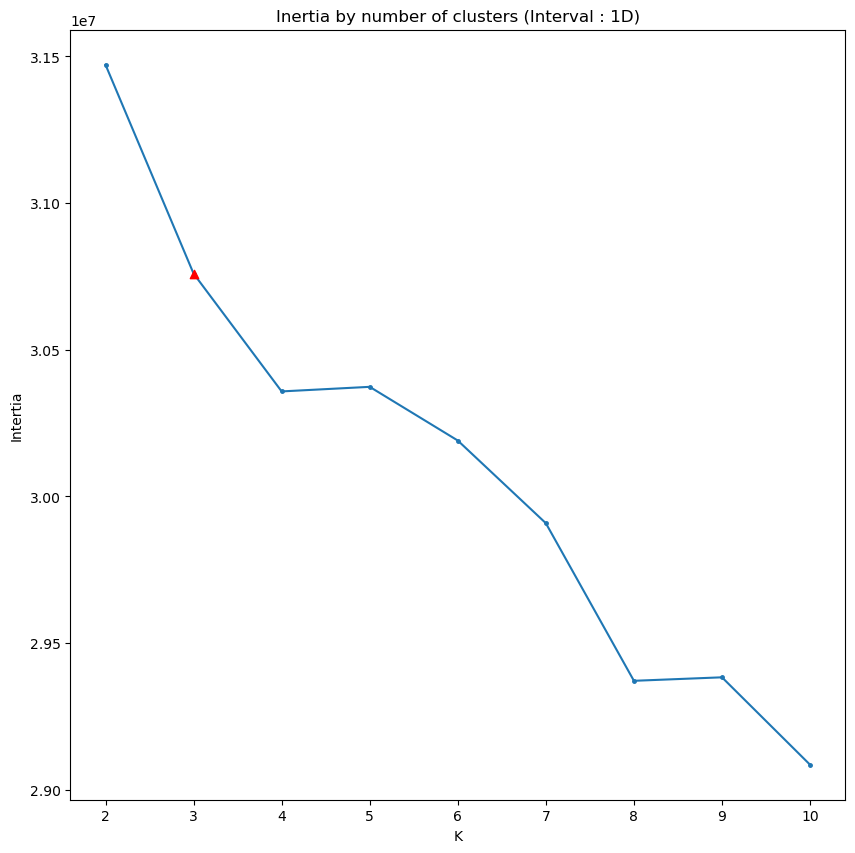

[31471954.752013206, 30759810.146197334, 30358173.622032855, 30373766.910870746, 30190717.333733276, 29908902.115537006, 29371566.841473036, 29383459.901423786, 29085473.998863257]
[712144.6058158726, 401636.5241644792, 15593.288837891072, 183049.57713747025, 281815.2181962691, 537335.2740639709, 11893.059950750321, 297985.90256052837]


In [13]:
list_intertia, list_intertia_deriv = com_clustering.clustering_elbow_method(str_interval, int_cluster_min, int_cluster_max, X_std
                                                                            , opt_X = 3)
print(list_intertia)
print(list_intertia_deriv)

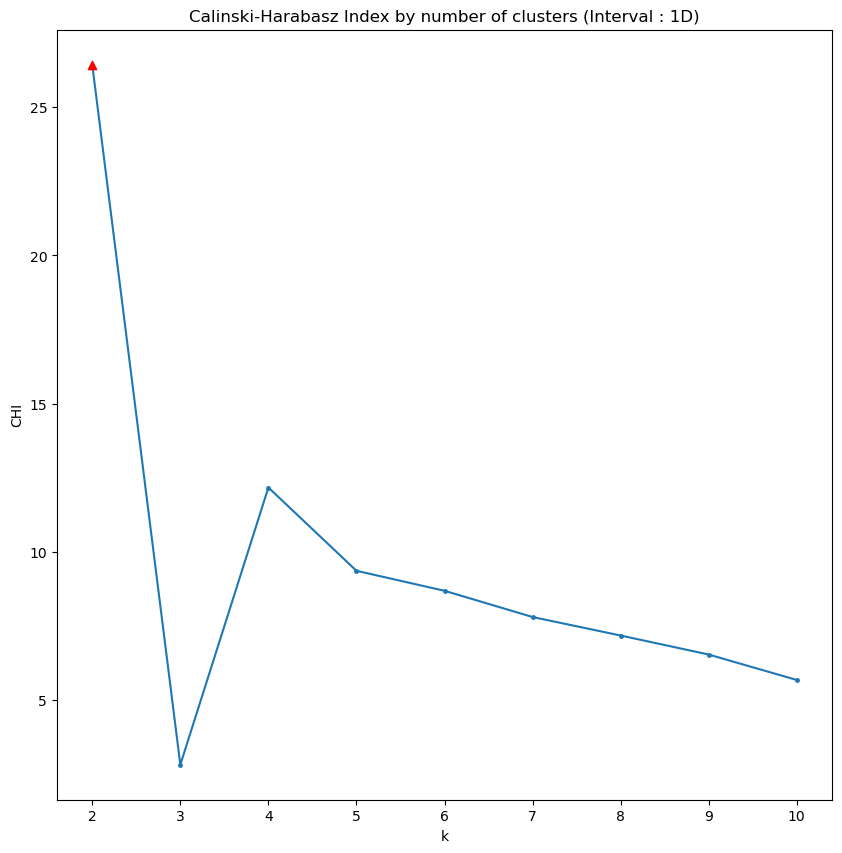

[26.432025647217046, 2.8256283570033283, 12.173802628576514, 9.365503910191553, 8.691281027263882, 7.806440507724997, 7.182501040144396, 6.540813406432412, 5.6834497928751695]


In [14]:
list_CHI = com_clustering.clustering_CHI_method(str_interval, int_cluster_min, int_cluster_max, X_std, 2)
print(list_CHI)

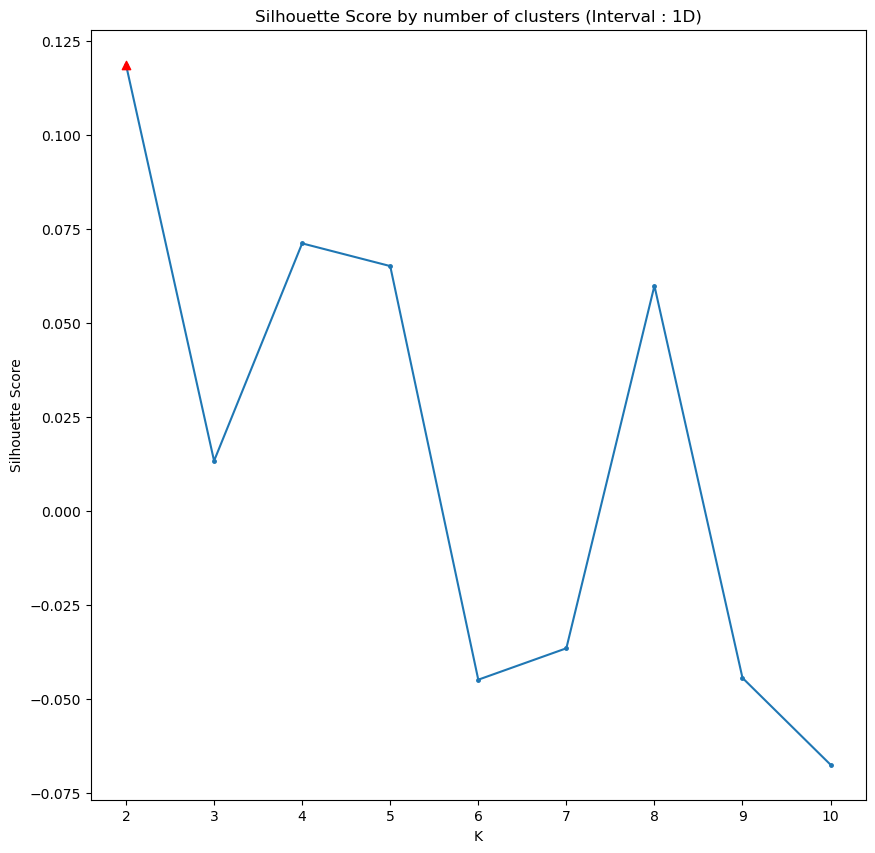

[0.11865604542115998, 0.013279428271069808, 0.07113615534297892, 0.06509691854822507, -0.044925055246432526, -0.03657006573986946, 0.05985686844448718, -0.04444536769049467, -0.0675421517974092]
[[237, 111], [143, 121, 84], [22, 197, 1, 128], [1, 185, 3, 138, 21], [1, 64, 124, 1, 1, 157], [88, 117, 1, 1, 139, 1, 1], [1, 180, 120, 41, 1, 1, 1, 3], [1, 1, 109, 2, 150, 24, 1, 1, 59], [1, 1, 73, 8, 1, 1, 21, 94, 52, 96]]


In [15]:
list_Silhouette, list_cnt_clusters_by_K = com_clustering.clustering_Silhouette_method(str_interval, int_cluster_min, int_cluster_max, X_std, 2)
print(list_Silhouette)
print(list_cnt_clusters_by_K)

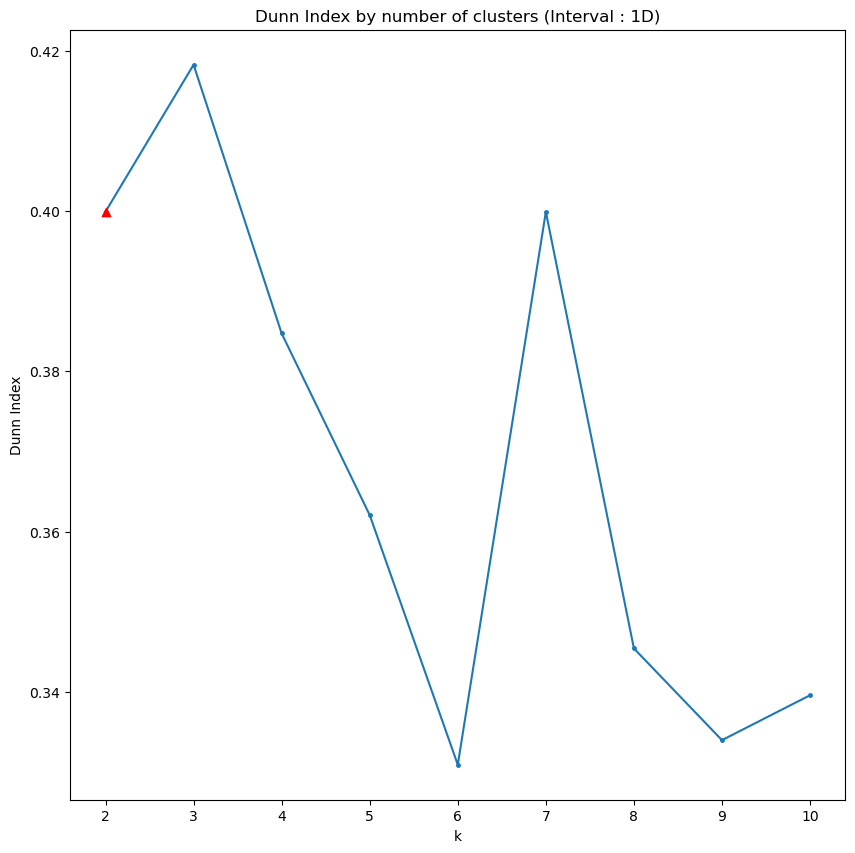

[0.3999189113793259,
 0.41826085030228793,
 0.3847339822799361,
 0.36206423838171303,
 0.33091088610461933,
 0.39990048551578455,
 0.34542331624728656,
 0.3339749567948418,
 0.3395830459361278]

In [16]:
from Src_Dev_Common.cluster_eval import get_Dunn_index

opt_X = 2

## 예외처리01
## Min이 Max보다 크면 그냥 바꿔줌 + Int가 아니면 Int로 바꿔줌
if int_cluster_min > int_cluster_max : int_clusters_min, int_clusters_max = int(int_cluster_max), int(int_cluster_min) + 1
else : int_clusters_min, int_clusters_max = int(int_cluster_min), int(int_cluster_max) + 1

## 초기 변수  생성
list_Dunn = []
K = range(int_clusters_min, int_clusters_max)

for n_cluster in K:
    km_dunn = KMeans(n_clusters = n_cluster
                    , init="k-means++"
                    , max_iter=300
                    , n_init=1).fit(X_std) 
    cluster = km_dunn.predict(X_std)
    list_Dunn.append(get_Dunn_index(X_std, cluster))

fig = plt.figure(figsize=(10,10))
fig.set_facecolor('white')
ax = fig.add_subplot()
ax.plot(K, list_Dunn, marker='.', markersize = 5, zorder = 2)
if opt_X != None : plt.scatter(opt_X, list_Dunn[opt_X - 2], color = 'red', marker = '^', label = 'Point', zorder = 9999)
ax.set_xticks(K)
plt.xlabel('k')
plt.ylabel('Dunn Index')
plt.title('Dunn Index by number of clusters (Interval : ' + str_interval + ')')
plt.show()

list_Dunn

In [17]:
print(end)

NameError: name 'end' is not defined

In [18]:
## 위에서 결정된 군집의 수에 따라 군집화 결과 도출
## 초기 변수 생성
K, cnt_loop = 2, 10 ## K : 결정된/평가할 군집의 수, cnt_loop : 평가를 위한 군집화 시도 횟수

km = KMeans(n_clusters = K, init="k-means++", max_iter=300, n_init=1).fit(X_std)
cluster = km.predict(X_std)

list_log_clusters = com_clustering.clustering_get_cnt_by_loop(K, cnt_loop, X_std)
print("총 " + str(cnt_loop) + "회에 걸친 군집화 시뮬레이션")
print(list_log_clusters)

총 10회에 걸친 군집화 시뮬레이션
[[207, 141], [1, 347], [141, 207], [1, 347], [347, 1], [237, 111], [141, 207], [237, 111], [207, 141], [1, 347]]


[111, 237]


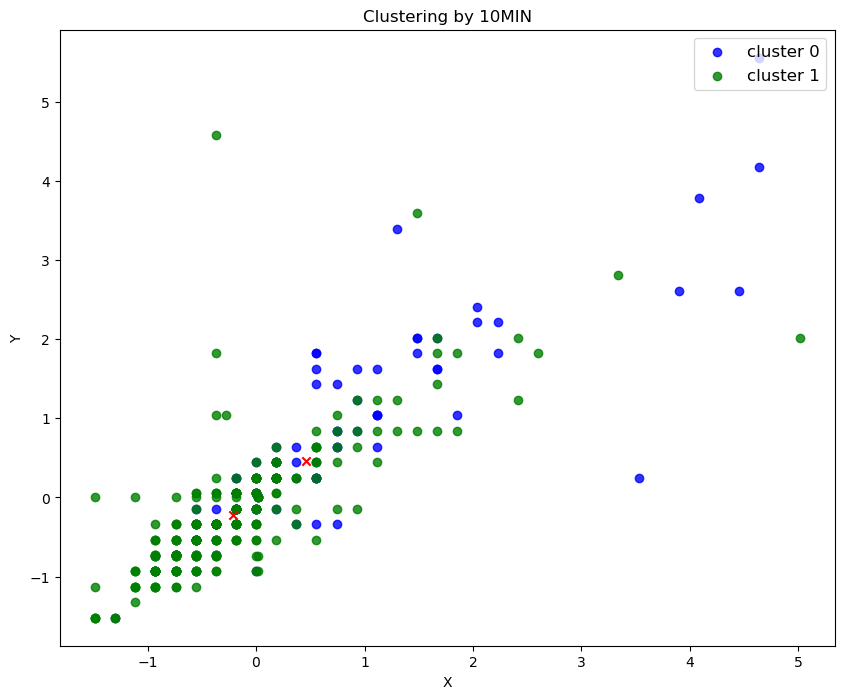

Silhouette Coefficient: 0.1187
Calinski and Harabasz score: 26.2350
Dunn Index : 0.4060
Davues Bouldin Score: 3.4221
Homogeneity: 0.1070
Completeness: 1.0000
V-measure: 0.1933
Rand-Index: 0.4357
Adjusted Rand-Index: 0.0000


In [18]:
## 최종 군집에 대한 군집화 평가
print(com_clustering.get_cluster_sizes(km, X_std)) ## 최종 군집화에 대한 군집 크기 출력

com_clustering.clustering_visualization(str_interval, km, X_std)
list_scores = com_clustering.get_clustring_score(km, X_std, y)

In [19]:
## 최종 군집에 대한 Labeled Data 저장
print(com_clustering.get_cluster_sizes(km, X_std)) ## 최종 군집화에 대한 군집 크기 출력
# df_kier_summary_total['target'] = np.transpose(np.where(km.labels_ == i)[0])
df_kier_summary_total['target_'+str_domain] = 0
for i in range(0, len(df_kier_summary_total)) : df_kier_summary_total['target_'+str_domain].iloc[i] = km.labels_[i]
# df_kier_summary_total[['h_index', 'target_' + str_domain]]

str_file_labeled = str_dirName_h + 'KIER_' + str(str_domain) + '_Labeled_' + str_interval + '_K' + str(K) + '.csv'
df_kier_summary_total = df_kier_summary_total[['h_index', 'target_'+str_domain]]
df_kier_summary_total.to_csv(str_file_labeled)
print(str_file_labeled)
df_kier_summary_total

[237, 111]
../data_Energy_KIER/KIER_3_H_ELEC/KIER_ELEC_Labeled_10MIN_K2.csv


METER_DATE,h_index,target_ELEC
0,ELEC_INST_EFF_561-1-1,1
1,ELEC_INST_EFF_561-1-2,1
2,ELEC_INST_EFF_561-1-3,0
3,ELEC_INST_EFF_561-1-4,1
4,ELEC_INST_EFF_561-2-1,1
...,...,...
343,ELEC_INST_EFF_563-23-2,1
344,ELEC_INST_EFF_563-23-3,0
345,ELEC_INST_EFF_563-23-4,0
346,ELEC_INST_EFF_563-24-1,0
